In [1]:
# import dependencies
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
gpu = ('cuda:0')

torch.Size([32, 1, 32, 32])
torch.Size([32])
Labels : tensor([5, 9, 4, 4, 1, 6, 2, 0, 7, 3, 5, 1, 6, 7, 7, 4, 3, 4, 7, 5, 3, 7, 2, 5,
        6, 9, 5, 2, 4, 3, 3, 6])


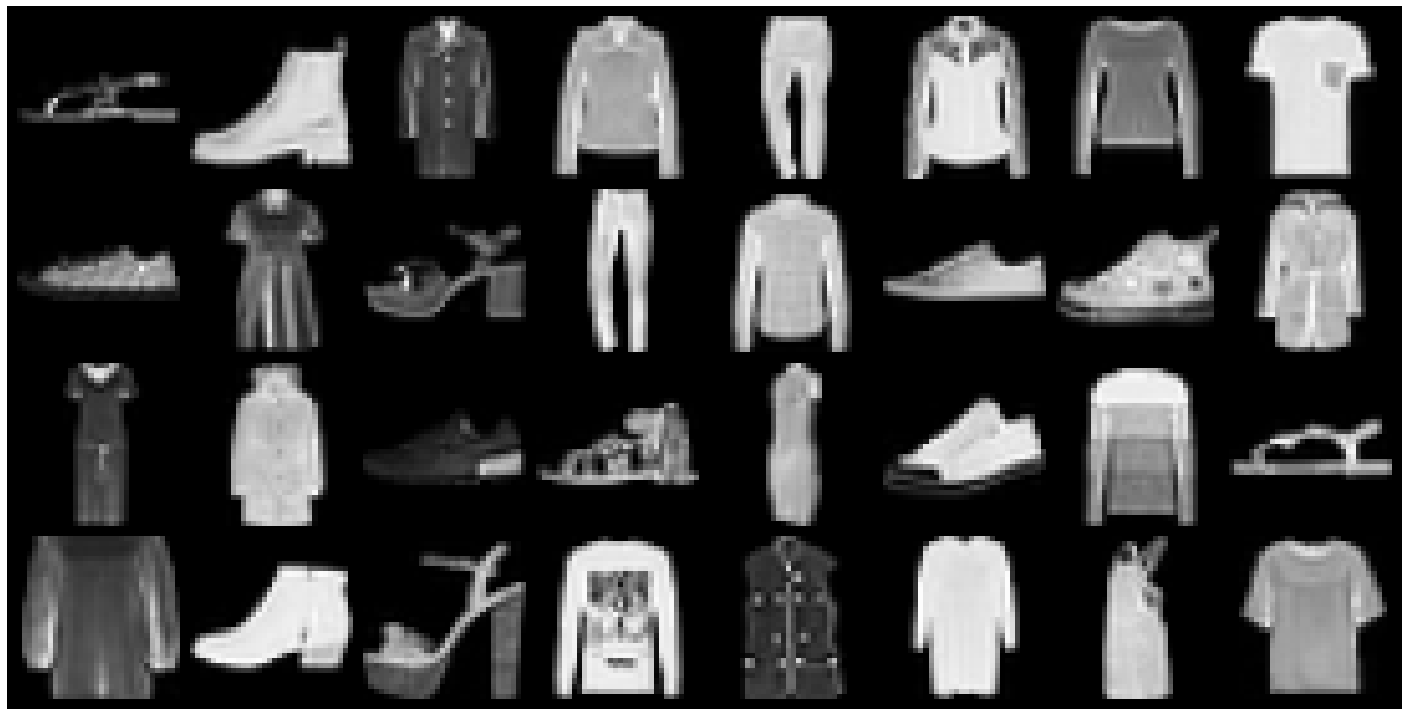

In [2]:
# fashionmnist data (real), just for plotting
_transforms = transforms.Compose([
    transforms.Resize((32, 32))
    ,transforms.ToTensor()
    ])
_dataset = datasets.FashionMNIST(root='dataset/', train=True, transform=_transforms, download=True)
_dataloader = DataLoader(_dataset, batch_size=32, shuffle=True)
_batch = next(iter(_dataloader))
_images, _labels = _batch
print(_images.shape)
print(_labels.shape)

grid = utils.make_grid(_images, nrow = 8)

plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
print("Labels :", _labels)

In [3]:
# discriminator class
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # in 1*32*32
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # in 16*16*16
            nn.Conv2d(feature_maps, feature_maps*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps*2),
            nn.LeakyReLU(0,2),
            # in 32*8*8
            nn.Conv2d(feature_maps*2, feature_maps*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps*4),
            nn.LeakyReLU(0,2),
            # in 64*4*4
            nn.Conv2d(feature_maps*4, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
            # out 1*1
            )

    def forward(self, x):
        return self.net(x)

In [4]:
# generator class
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, feature_maps):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # in 256*1*1
            nn.ConvTranspose2d(noise_channels, feature_maps*16, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_maps*16),
            nn.ReLU(),  
            # in 256*4*4  
            nn.ConvTranspose2d(feature_maps*16, feature_maps*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps*8),
            nn.ReLU(),
            # in 128*8*8  
            nn.ConvTranspose2d(feature_maps*8, feature_maps*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(),
            # in 64*16*16
            nn.ConvTranspose2d(feature_maps*4, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # out 1*32*32
            )

    def forward(self, x):
        return self.net(x)

In [5]:
# discriminator model
discriminator = Discriminator(1, 16).to(gpu)
print(discriminator)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (9): Sigmoid()
  )
)


In [6]:
# generator model
generetor = Generator(256, 1, 16).to(gpu)
print(generetor)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)


In [7]:
# training data
train_transforms = transforms.Compose([
    transforms.Resize((32, 32))
    ,transforms.ToTensor()
    ,transforms.Normalize((0.5), (0.5))
])

dataset = datasets.FashionMNIST(root='dataset/', train=True, transform=train_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)

print("Number of Classes : ", len(dataset.class_to_idx))
print("Classes : ", dataset.class_to_idx)
print("Number of Training Samples : ", len(dataset))

Number of Classes :  10
Classes :  {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Number of Training Samples :  60000


In [8]:
# optimizer, criterion
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_g = torch.optim.Adam(generetor.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [ ]:
# train
loss_discriminator = []
loss_generator = []

for epoch in range(500):

    t0 = time.time()
    running_loss_d = 0.0
    running_loss_g = 0.0
    discriminator.train()
    generetor.train()

    for images, _ in dataloader:
        images = images.to(gpu)
        batch_size = images.shape[0]

        discriminator.zero_grad()
        labels = (torch.ones(batch_size)*0.9).to(gpu)
        out = discriminator(images).reshape(-1)
        loss_d_real = criterion(out, labels)

        noise = torch.randn(batch_size, 256, 1, 1).to(gpu)
        fake_imgs = generetor(noise)
        labels = (torch.ones(batch_size)*0.1).to(gpu)
        out = discriminator(fake_imgs.detach()).reshape(-1)
        loss_d_fake = criterion(out, labels)

        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optim_d.step()

        running_loss_d += loss_d.item()

        generetor.zero_grad()
        labels = torch.ones(batch_size).to(gpu)
        out = discriminator(fake_imgs).reshape(-1)
        loss_g = criterion(out, labels)
        loss_g.backward()
        optim_g.step()

        running_loss_g += loss_g.item()

    epoch_loss_d = running_loss_d/len(dataloader.dataset)*2
    epoch_loss_g = running_loss_g/len(dataloader.dataset)
    loss_discriminator.append(epoch_loss_d)
    loss_generator.append(epoch_loss_g)
    
    print('----------------------------------------------------------------')
    print('epoch: ', (epoch + 1))   
    print('----------------------------------------------------------------')
    print('discriminator loss: {:.4f}'.format(epoch_loss_d))
    print('generator loss: {:.4f}'.format(epoch_loss_g))
    print('epoch time: {:.4f} seconds'.format(time.time() - t0))

    checkpoint = {
        'epoch': epoch + 1
        ,'gen_state_dict': generetor.state_dict()
        ,'gen_optimizer' : optim_g.state_dict()
        ,'gen_loss' : epoch_loss_g
        ,'list_gen_loss' : loss_generator
        ,'disc_state.dict' : discriminator.state_dict()
        ,'disc_optimizer' : optim_d.state_dict()
        ,'disc_loss' : epoch_loss_d
        ,'list_disc_loss' : loss_discriminator
        }
    
    # saving generator, every epoch
    torch.save(checkpoint, 'drive/My Drive/Colab Notebooks/FasMNIST_GANs_PyTorch/checkpoint/gans_fashionmnist_epoch_{}.pth'.format(epoch + 1))

    # saving last batch generated fake images, every epoch
    fake_imgs = fake_imgs.reshape(-1, 1, 32, 32)
    fake_imgs = (fake_imgs + 1) / 2
    save_image(fake_imgs, 'drive/My Drive/Colab Notebooks/FasMNIST_GANs_PyTorch/test/fake images epoch {}.png'.format(epoch + 1))

----------------------------------------------------------------
epoch:  1
----------------------------------------------------------------
discriminator loss: 0.0600
generator loss: 0.0465
epoch time: 37.5346 seconds
----------------------------------------------------------------
epoch:  2
----------------------------------------------------------------
discriminator loss: 0.0638
generator loss: 0.0412
epoch time: 37.3934 seconds
----------------------------------------------------------------
epoch:  3
----------------------------------------------------------------
discriminator loss: 0.0598
generator loss: 0.0458
epoch time: 37.1058 seconds
----------------------------------------------------------------
epoch:  4
----------------------------------------------------------------
discriminator loss: 0.0541
generator loss: 0.0539
epoch time: 36.9724 seconds
----------------------------------------------------------------
epoch:  5
-----------------------------------------------------

In [9]:
# load checkpoint 
checkpoint = torch.load('checkpoint/gans_fashionmnist_epoch_500.pth')

last_epoch = checkpoint['epoch']

generetor.load_state_dict(checkpoint['gen_state_dict'])
optim_g.load_state_dict(checkpoint['gen_optimizer'])
gen_loss_old = checkpoint['gen_loss']
list_gen_loss_old = checkpoint['list_gen_loss']

discriminator.load_state_dict(checkpoint['disc_state.dict'])
optim_d.load_state_dict(checkpoint['disc_optimizer'])
disc_loss_old = checkpoint['disc_loss']
list_disc_loss_old = checkpoint['list_disc_loss']

In [10]:
print('last epoch: {}'.format(last_epoch))
print('last discriminator loss: {:.4f}'.format(disc_loss_old))
print('last generator loss: {:.4f}'.format(gen_loss_old))

last epoch: 500
last discriminator loss: 0.0419
last generator loss: 0.0723


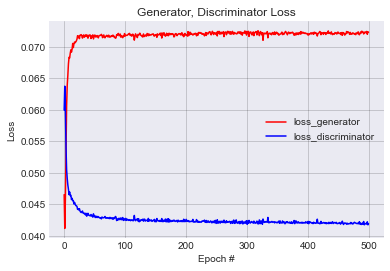

In [12]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(list_gen_loss_old, color = 'red')
plt.plot(list_disc_loss_old, color = 'blue')
plt.title('Generator, Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['loss_generator', 'loss_discriminator'], loc = 'center right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
# plt.savefig('graphs/fasmnist_gans_loss.png', dpi = 100)

(-0.5, 273.5, 137.5, -0.5)

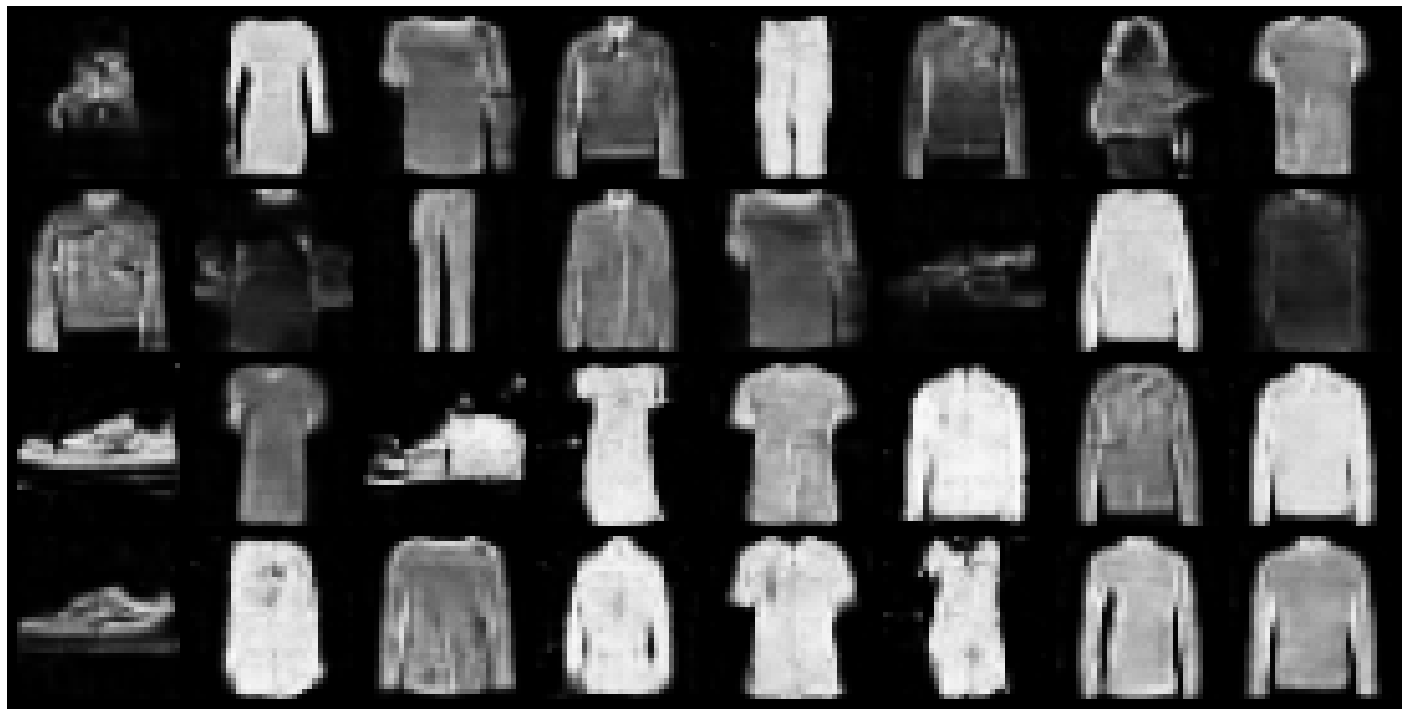

In [16]:
noise = torch.randn(32, 256, 1, 1).to(gpu)
result = generetor(noise)
image = result.detach()
image = image.cpu()
image = (image + 1) / 2
grid = utils.make_grid(image, nrow = 8)
plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')

In [19]:
generated_images = result.shape[0]
for i in range(generated_images):
    a = image[i].numpy().transpose((1,2,0))
    b = cv2.resize(a, dsize=(300, 300))
    cv2.imshow("Generated Image",b)
    cv2.waitKey(0)
    cv2.destroyAllWindows()